# imports

In [1]:
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import time
import matplotlib.image as mpimg
from matplotlib import cm
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import cv2
import math
%matplotlib inline

# We plan to use Support vector classifier in this project, so we found a dataset online to use

## Loading dataset

In [2]:
vehicle_images=[]
non_vehicle_images=[]

for root,dirs,files in os.walk('./vehicles/'):
    for file in files:
        if file.endswith('.png'):
            vehicle_images.append(os.path.join(root, file))


for root,dirs,files in os.walk('./non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            non_vehicle_images.append(os.path.join(root, file))

In [3]:
v_images_number=len(vehicle_images)
nv_images_number=len(non_vehicle_images)
print('number of car images: ',v_images_number)
print('number of non-car images: ',nv_images_number)
print('shape of images: ',cv2.imread(vehicle_images[0]).shape)

number of car images:  8792
number of non-car images:  5414
shape of images:  (64, 64, 3)


### Random vehicle images

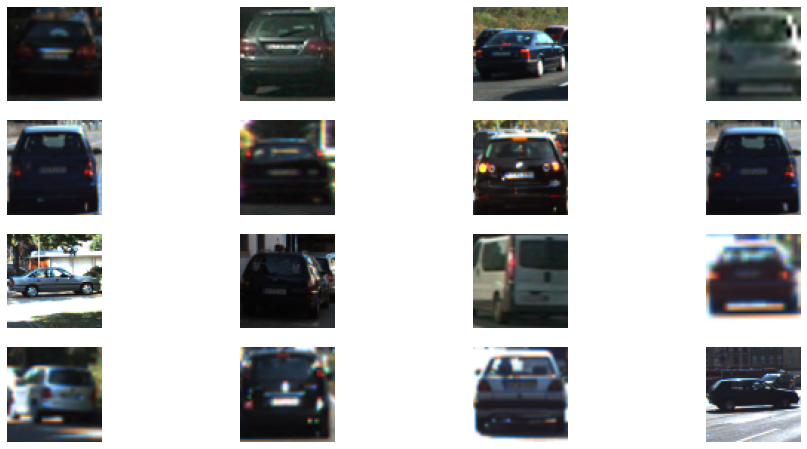

In [4]:
fig,ax=plt.subplots(4,4,figsize=(16,8))
ax= ax.ravel()

for i in range(16):
    image = cv2.imread(vehicle_images[np.random.randint(0,v_images_number)])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].imshow(image)

### Random non vehicle images

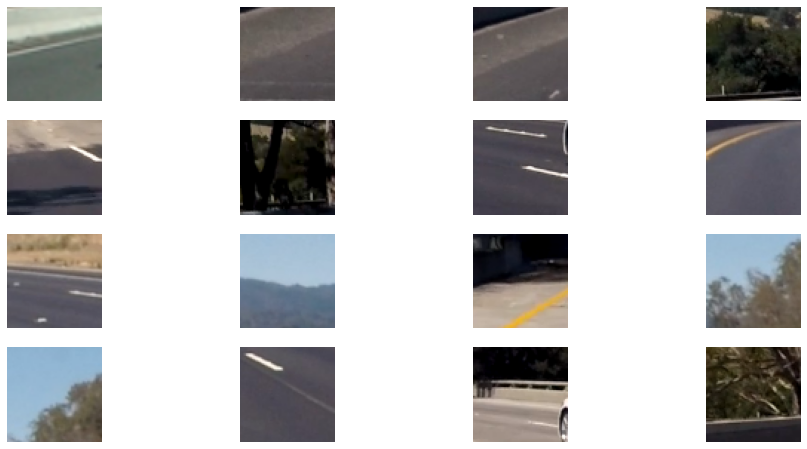

In [5]:
fig,ax=plt.subplots(4,4,figsize=(16,8))
ax= ax.ravel()

for i in range(16):
    image = cv2.imread(non_vehicle_images[np.random.randint(0,nv_images_number)])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].imshow(image)

## Hog Feature Extraction

In [6]:
# Compute binned color features by scaling images down 
def get_feature_vector(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    feature_vector = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return feature_vector


In [7]:
# Compute color histogram features  
def get_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Returning HOG features

In [14]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return hog_features

In [22]:
# Extract feature wrapper that extracts and combines all features
def extract_and_combine(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        image = cv2.imread(img)
        # apply color conversion if other than 'RGB' 
            
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = get_feature_vector(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = get_hist_features(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

### Visualizing HOG Feature Extraction

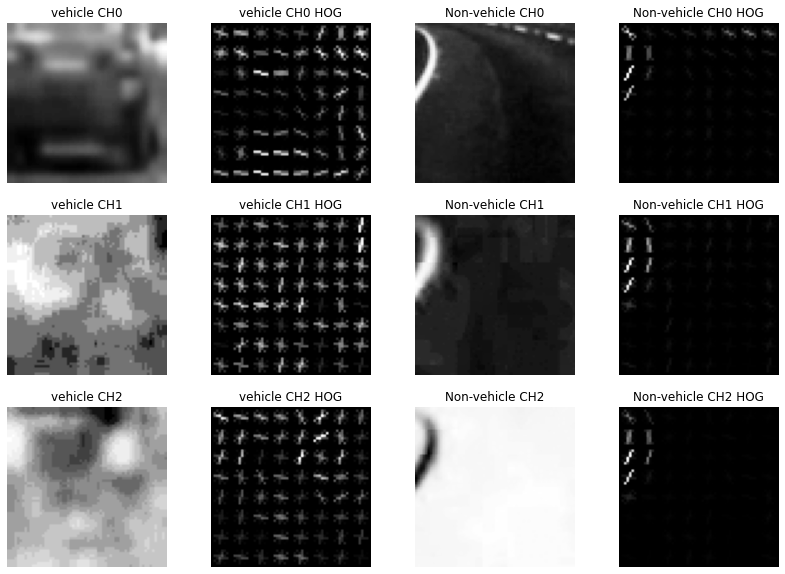

In [23]:
test_image = cv2.imread(vehicle_images[13])
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2YCrCb)
non_car_test_image = mpimg.imread(non_vehicle_images[7])
non_car_test_image = cv2.cvtColor(non_car_test_image, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([test_image, non_car_test_image], ['vehicle', 'Non-vehicle']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')

## Extracting Features for model

In [24]:
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

car_features = extract_and_combine(vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

non_car_features = extract_and_combine(non_vehicle_images,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
